<a href="https://colab.research.google.com/github/bkepecs/DeepLearningCancerDetection/blob/main/deep_learning_cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This pipeline uses Tensorflow to train an InceptionV3 convolutional neural network to detect cancer in pathology images. See [here](https://) for more details.

The aim of this project was to reproduce the results from [this](https://arxiv.org/pdf/1703.02442.pdf) paper using original code and methods.

# Setup

Install the OpenSlide C library and Python bindings. After installing these libraries, use `Runtime -> restart and run all` on the menu

In [ ]:
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import required packages.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import shutil
import pathlib
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Download slides for training

Let's download 11 slides for training from the storage bucket, plus 1 for generating a testing dataset.

In [ ]:
def download_slides(slidenames, destination):
  for slidename in slidenames:
    print("Downloading %s" % slidename)
    slide_path = "%s.tif" % slidename
    tumor_mask_path = '%s_mask.tif' % slidename

    url = 'adl-bek2127/pathology_slides'
    if slidename == 'tumor_091':
      url = 'applied-dl'
    elif slidename == 'tumor_078' or slidename == 'tumor_081':
      url = 'applied-dl/slides'

    slide_url = 'https://storage.googleapis.com/%s/%s' % (url, slide_path)
    mask_url = 'https://storage.googleapis.com/%s/%s' % (url, tumor_mask_path)

    # Download the whole slide image
    if not os.path.exists(slide_path):
      !curl -O $slide_url
      !mv $slide_path $destination

    # Download the tumor mask
    if not os.path.exists(tumor_mask_path):
      !curl -O $mask_url
      !mv $tumor_mask_path $destination

In [ ]:
slidenames = ['tumor_001', 'tumor_002', 'tumor_005',  
              'tumor_012', 'tumor_016','tumor_019',
              'tumor_023', 'tumor_031', 'tumor_035',
              'tumor_057']
training_slide_path = "/content/training_slides"
if not os.path.exists(training_slide_path):
  os.mkdir(training_slide_path)

download_slides(slidenames, training_slide_path)

In [ ]:
slidenames = ['tumor_091']
testing_slide_path = "/content/testing_slides"
if not os.path.exists(testing_slide_path):
  os.mkdir(testing_slide_path)

download_slides(slidenames, testing_slide_path)

# Patch extraction

Now we go through the 10 training slides and extract 299x299 patches from each slide at two levels: level 2 and level 3. Each level 2 patch corresponds to a level 3 patch at the same location but zoomed out. We're only collecting patches with tissue percent > 50%, and we're basing ground truth off the masks provided.

In [ ]:
### Utility functions

# Read a region from the slide, return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

# Find non-gray regions
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

In [ ]:
DIM = 299

# Generate directories to store training/testing data
def make_directories(dataset):
  if not os.path.exists("%s_dataset" % dataset):
    os.mkdir("%s_dataset" % dataset)
  if not os.path.exists("%s_dataset/cancer" % dataset):
    os.mkdir("%s_dataset/cancer" % dataset)
  if not os.path.exists("%s_dataset/benign" % dataset):
    os.mkdir("%s_dataset/benign" % dataset)

# Adjust pixel index to deal with image borders
def get_index(i, j, width, height, dim):
  column = i
  row = j
  if i + dim >= width and j + dim >= height:
    column = width-dim-1
    row = height-dim-1    
  elif i + dim >= width:
    column = width-dim-1
    row = j
  elif j + dim >= height:
    column = i
    row = height-dim-1
  return column, row

# Calculate the percent of a region that is tissue
def calculate_percent_tissue(image_region):
  tissue_pixels = find_tissue_pixels(image_region)
  percent_tissue = len(tissue_pixels) / float(image_region.shape[0] * image_region.shape[1]) * 100
  percent_tissue = round(percent_tissue, 1)
  return percent_tissue

# Save training image
def save_image(image_region, level, category, slidename, patch_index, dataset):
  im = Image.fromarray(image_region)
  im.save("%s_dataset/%s/%s-%s-level%d-%d.jpg" % (dataset, category, category, slidename, level, patch_index))

# Extract patches from each slide at two levels and save as training images
def extract_patches(slide, tumor_mask, slidename, level, second_level, dataset):
  print("Extracting patches at levels %d and %d" % (level, second_level))
  make_directories(dataset)

  WIDTH = slide.level_dimensions[level][0]
  HEIGHT = slide.level_dimensions[level][1]
  
  patch_index = 1
  for i in range(0, WIDTH, DIM):
    for j in range(0, HEIGHT, DIM):
      column, row = get_index(i, j, WIDTH, HEIGHT, DIM)
      
      image_region = read_slide(slide,
                                x=int(column * slide.level_downsamples[level]), 
                                y=int(row * slide.level_downsamples[level]),
                                level=level, width=DIM, height=DIM)
      mask_region = read_slide(tumor_mask,
                              x=int(column * slide.level_downsamples[level]), 
                              y=int(row * slide.level_downsamples[level]), 
                              level=level, width=DIM, height=DIM)[:,:,0]
      image_region_2 = read_slide(slide,
                                x=int((column/2) * slide.level_downsamples[second_level]), 
                                y=int((row/2) * slide.level_downsamples[second_level]),
                                level=second_level, width=DIM, height=DIM)

      percent_tissue = calculate_percent_tissue(image_region)
      
      if (percent_tissue > 50):
        if np.any(mask_region):
          save_image(image_region, level, 'cancer', slidename, patch_index, dataset)
          save_image(image_region_2, second_level, 'cancer', slidename, patch_index, dataset)
        else:
          save_image(image_region, level, 'benign', slidename, patch_index, dataset)
          save_image(image_region_2, second_level, 'benign', slidename, patch_index, dataset)
      patch_index += 1

  print("Done extracting patches from %s!" % slidename)

In [ ]:
# Opens a downloaded slide using OpenSlide
def get_slide(slidename, group):
  slide_path = "/content/%s_slides/%s.tif" % (group, slidename)
  tumor_mask_path = "/content/%s_slides/%s_mask.tif" % (group, slidename)
  slide = open_slide(slide_path)
  print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))
  for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
  tumor_mask = open_slide(tumor_mask_path)
  return slide, tumor_mask

In [ ]:
levels = [2, 3]
training_slidenames = ['tumor_001', 'tumor_002', 'tumor_005', 
                       'tumor_012', 'tumor_016', 'tumor_019',
                       'tumor_023', 'tumor_031', 'tumor_035', 
                       'tumor_057']
for slidename in training_slidenames:
  slide, tumor_mask = get_slide(slidename, 'training')
  extract_patches(slide, tumor_mask, slidename, levels[0], levels[1], 'training')

In [ ]:
levels = [2, 3]
testing_slidenames = ['tumor_091']
for slidename in testing_slidenames:
  slide, tumor_mask = get_slide(slidename, 'testing')
  extract_patches(slide, tumor_mask, slidename, levels[0], levels[1], 'testing')

How many patches did we collect?

In [ ]:
num_benign = len(os.listdir('training_dataset/benign'))
num_cancer = len(os.listdir('training_dataset/cancer'))
print("%d benign patches and %d cancer patches collected for training" % (num_benign, num_cancer))

num_benign = len(os.listdir('testing_dataset/benign'))
num_cancer = len(os.listdir('testing_dataset/cancer'))
print("%d benign patches and %d cancer patches collected for testing" % (num_benign, num_cancer))

Split up the sampled patches into two folders: one for level 2 and one for level 3.

In [ ]:
levels = [2, 3]
for level in levels:
  if not os.path.exists("training_dataset%d" % level):
    os.mkdir("training_dataset%d" % level)
    os.mkdir("training_dataset%d/benign" % level)
    os.mkdir("training_dataset%d/cancer" % level)
  !cp training_dataset/benign/*level{level}* training_dataset{level}/benign
  !cp training_dataset/cancer/*level{level}* training_dataset{level}/cancer
  
  if not os.path.exists("testing_dataset%d" % level):
    os.mkdir("testing_dataset%d" % level)
    os.mkdir("testing_dataset%d/benign" % level)
    os.mkdir("testing_dataset%d/cancer" % level)
  !cp testing_dataset/benign/*level{level}* testing_dataset{level}/benign
  !cp testing_dataset/cancer/*level{level}* testing_dataset{level}/cancer

In [ ]:
num_benign = len(os.listdir('training_dataset2/benign'))
num_cancer = len(os.listdir('training_dataset2/cancer'))
print("%d benign patches and %d cancer patches collected for training at level 2" % (num_benign, num_cancer))

num_benign = len(os.listdir('training_dataset3/benign'))
num_cancer = len(os.listdir('training_dataset3/cancer'))
print("%d benign patches and %d cancer patches collected for training at level 3" % (num_benign, num_cancer))

Let's balance the datasets so that we have equal numbers benign and cancer patches in the training and testing sets. 

In [ ]:
def balance_dataset(dataset):
  num_benign = len(os.listdir("%s_dataset2/benign" % dataset))
  num_cancer = len(os.listdir("%s_dataset2/cancer" % dataset))
  num_to_trim = num_benign - num_cancer

  level2_files = os.listdir("%s_dataset2/benign" % dataset)
  level3_files = os.listdir("%s_dataset3/benign" % dataset)

  level2_files.sort()
  level3_files.sort()

  number_of_files = len(level2_files)
  numbers_to_delete = random.sample(range(0, number_of_files), num_to_trim)
  for number in numbers_to_delete:
    level2_file = level2_files[number]
    level3_file = level3_files[number]
    os.remove("%s_dataset2/benign/%s" % (dataset, level2_file))
    os.remove("%s_dataset3/benign/%s" % (dataset, level3_file))

In [ ]:
balance_dataset('training')
balance_dataset('testing')

# Model training

We're going to use a multi-input model, so here I'm collecting lists of input_1, input_2, and the label associated with each (input_1, input_2) pair.

In [ ]:
levels = [2,3]
BATCH_SIZE = 32
HEIGHT = 299
WIDTH = 299

In [ ]:
def generate_inputs(dataset, levels):
  dir_1 = pathlib.Path("/content/%s_dataset%d" % (dataset, levels[0]))
  dir_2 = pathlib.Path("/content/%s_dataset%d" % (dataset, levels[1]))

  ds_1 = tf.keras.utils.image_dataset_from_directory(
    dir_1,
    shuffle=False,
    image_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE)
  ds_2 = tf.keras.utils.image_dataset_from_directory(
    dir_2,
    shuffle=False,
    image_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE)
  
  images_1 = []
  labels_1 = []
  for batch in ds_1.as_numpy_iterator():
    for image in batch[0]:
      images_1.append(image)
    for label in batch[1]:
      labels_1.append(label)
  images_1 = np.array(images_1)
  labels_1 = np.array(labels_1)

  images_2 = []
  labels_2 = []
  for batch in ds_2.as_numpy_iterator():
    for image in batch[0]:
      images_2.append(image)
    for label in batch[1]:
      labels_2.append(label)
  images_2 = np.array(images_2)
  labels_2 = np.array(labels_2)

  return images_1, images_2, labels_1

In [ ]:
training_images_level2, training_images_level3, training_labels = generate_inputs(
    'training', levels)
testing_images_level2, testing_images_level3, testing_labels = generate_inputs(
    'testing', levels)

Found 788 files belonging to 2 classes.
Found 788 files belonging to 2 classes.
Found 138 files belonging to 2 classes.
Found 138 files belonging to 2 classes.


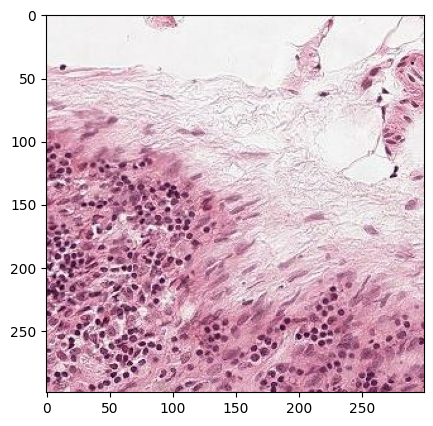

In [ ]:
patch = training_images_level2[150].astype(int)
plt.figure(figsize=(5,5), dpi=100)
plt.imshow(patch)

Apply color augmentation to the images like in the paper.

In [ ]:
def augment(x):
  x = tf.image.random_saturation(x, 0, 0.25)
  x = tf.image.random_hue(x, 0.04)
  x = tf.image.random_contrast(x, 0, 0.25)
  return x

for i in range(0, training_images_level2.shape[0]):
  training_images_level2[i,:,:,:] = augment(training_images_level2[i,:,:,:])
  training_images_level3[i,:,:,:] = augment(training_images_level3[i,:,:,:])

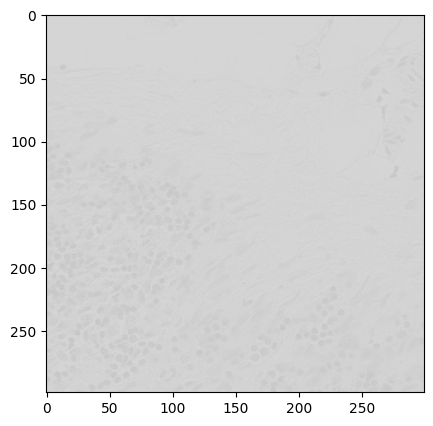

In [ ]:
patch = training_images_level2[150].astype(int)
plt.figure(figsize=(5,5), dpi=100)
plt.imshow(patch)

Define all the components of the model.

In [ ]:
# An additional data augmentation layer
data_augmentation_1 = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
], name="DataAugmentation_1")

data_augmentation_2 = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
], name="DataAugmentation_2")

# InceptionV3 base models on which we will do transfer learning
base_model_1 = tf.keras.applications.inception_v3.InceptionV3(include_top=False,
                                                weights='imagenet',
                                                input_shape=(HEIGHT, 
                                                             WIDTH, 3))
base_model_2 = tf.keras.applications.inception_v3.InceptionV3(include_top=False,
                                                weights='imagenet',
                                                input_shape=(HEIGHT, 
                                                             WIDTH, 3))
base_model_1.trainable = False
base_model_2.trainable = False

inception_1 = Sequential(name="InceptionV3_1")
inception_1.add(base_model_1)
inception_2 = Sequential(name="InceptionV3_2")
inception_2.add(base_model_2)

In [ ]:
# Define the multiscale model
input_1 = tf.keras.Input(shape=(HEIGHT, WIDTH, 3), name="Image_level2")
x = data_augmentation_1(input_1)
x = tf.keras.applications.inception_v3.preprocess_input(x)
x = inception_1(x, training=False) 
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.Model(input_1, x)

input_2 = tf.keras.Input(shape=(HEIGHT, WIDTH, 3), name="Image_level3")
y = data_augmentation_2(input_2)
y = tf.keras.applications.inception_v3.preprocess_input(y)
y = inception_2(y, training=False)
y = tf.keras.layers.GlobalAveragePooling2D()(y)
y = tf.keras.layers.Dropout(0.2)(y)
y = tf.keras.Model(input_2, y)

z = tf.keras.layers.concatenate([x.output, y.output])
z = tf.keras.layers.Dense(64, activation='relu')(z)
z = tf.keras.layers.Dropout(0.3)(z)
z = tf.keras.layers.Dense(8, activation='relu')(z)
z = tf.keras.layers.Dense(1)(z)

model = tf.keras.Model(inputs=[x.input, y.input], outputs=z)

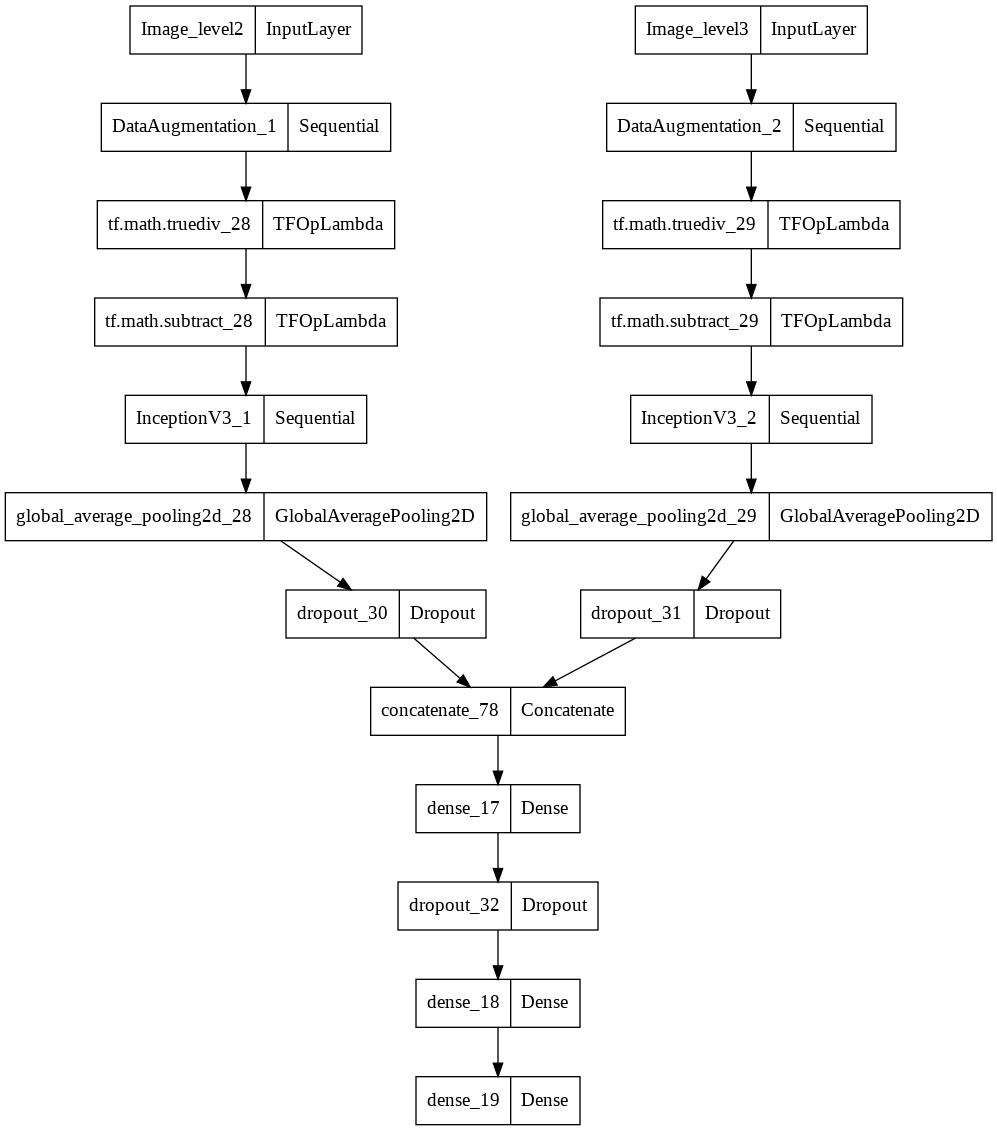

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

Let's train the model with the base layers frozen (for now).

In [ ]:
lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

initial_epochs = 10
history = model.fit(x=[training_images_level2, training_images_level3],
                    y=training_labels,
                    batch_size=BATCH_SIZE,
                    epochs=initial_epochs,
                    validation_data=([testing_images_level2, testing_images_level3], 
                                     testing_labels))

Epoch 1/10
25/25 [==============================] - 21s 461ms/step - loss: 0.5490 - accuracy: 0.6701 - val_loss: 0.9863 - val_accuracy: 0.5000
Epoch 2/10
25/25 [==============================] - 8s 337ms/step - loss: 0.4077 - accuracy: 0.8046 - val_loss: 0.9978 - val_accuracy: 0.5000
Epoch 3/10
25/25 [==============================] - 8s 340ms/step - loss: 0.3135 - accuracy: 0.8528 - val_loss: 1.5934 - val_accuracy: 0.5000
Epoch 4/10
25/25 [==============================] - 8s 338ms/step - loss: 0.3249 - accuracy: 0.8503 - val_loss: 1.1971 - val_accuracy: 0.5072
Epoch 5/10
25/25 [==============================] - 8s 331ms/step - loss: 0.2894 - accuracy: 0.8731 - val_loss: 0.6130 - val_accuracy: 0.6594
Epoch 6/10
25/25 [==============================] - 8s 330ms/step - loss: 0.2890 - accuracy: 0.8820 - val_loss: 1.0482 - val_accuracy: 0.5217
Epoch 7/10
25/25 [==============================] - 8s 328ms/step - loss: 0.2716 - accuracy: 0.8871 - val_loss: 1.0643 - val_accuracy: 0.5072
Epoch

Now we fine tune the model.

In [ ]:
fine_tune_at = 150

base_model_1.trainable = True
for layer in base_model_1.layers[:fine_tune_at]:
  layer.trainable = False

base_model_2.trainable = True
for layer in base_model_2.layers[:fine_tune_at]:
  layer.trainable = False

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr/10),
              metrics=['accuracy'])

total_epochs = initial_epochs + 10

history = model.fit(x=[training_images_level2, training_images_level3],
                    y=training_labels,
                    batch_size=BATCH_SIZE,
                    epochs=total_epochs,
                    initial_epoch=history.epoch[-1],
                    validation_data=([testing_images_level2, testing_images_level3], 
                                     testing_labels))

Epoch 10/20
25/25 [==============================] - 35s 695ms/step - loss: 0.2415 - accuracy: 0.8883 - val_loss: 0.7425 - val_accuracy: 0.6739
Epoch 11/20
25/25 [==============================] - 14s 581ms/step - loss: 0.2137 - accuracy: 0.9048 - val_loss: 0.6919 - val_accuracy: 0.6739
Epoch 12/20
25/25 [==============================] - 14s 576ms/step - loss: 0.1775 - accuracy: 0.9239 - val_loss: 0.5981 - val_accuracy: 0.7319
Epoch 13/20
25/25 [==============================] - 14s 566ms/step - loss: 0.1725 - accuracy: 0.9365 - val_loss: 0.8056 - val_accuracy: 0.6594
Epoch 14/20
25/25 [==============================] - 14s 562ms/step - loss: 0.1354 - accuracy: 0.9530 - val_loss: 0.5745 - val_accuracy: 0.7681
Epoch 15/20
25/25 [==============================] - 14s 565ms/step - loss: 0.1419 - accuracy: 0.9454 - val_loss: 0.8605 - val_accuracy: 0.7246
Epoch 16/20
25/25 [==============================] - 14s 567ms/step - loss: 0.1356 - accuracy: 0.9416 - val_loss: 0.7090 - val_accuracy:

Text(0.5, 1.0, 'Training and Validation Accuracy')

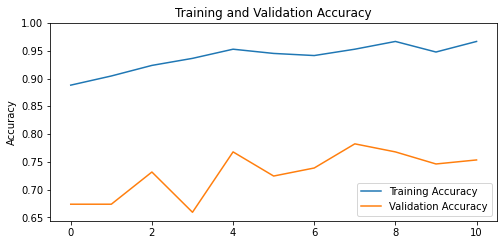

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

Now we evaluate the accuracy of the model on our withheld testing set.

In [ ]:
loss, accuracy = model.evaluate(x=[testing_images_level2, testing_images_level3], 
                                y=testing_labels)
print("Test accuracy: ", accuracy)

5/5 [==============================] - 1s 214ms/step - loss: 0.8590 - accuracy: 0.7536
Test accuracy:  0.7536231875419617


Not too bad! Let's save the model.

In [ ]:
model.save('trained_model')
!zip -r trained_model.zip trained_model

  adding: trained_model/ (stored 0%)
  adding: trained_model/saved_model.pb (deflated 92%)
  adding: trained_model/variables/ (stored 0%)
  adding: trained_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: trained_model/variables/variables.index (deflated 80%)
  adding: trained_model/assets/ (stored 0%)
  adding: trained_model/keras_metadata.pb (deflated 96%)


# Inference on new slides

In [ ]:
slidenames = ['tumor_078', 'tumor_081']
testing_slide_path = "/content/testing_slides"
if not os.path.exists(testing_slide_path):
  os.mkdir(testing_slide_path)

download_slides(slidenames, testing_slide_path)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1626M  100 1626M    0     0  22.5M      0  0:01:12  0:01:12 --:--:-- 22.9M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 49.7M  100 49.7M    0     0  16.5M      0  0:00:03  0:00:03 --:--:-- 16.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1118M  100 1118M    0     0  23.2M      0  0:00:48  0:00:48 --:--:-- 23.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 39.1M  100 39.1M    0     0  17.1M      0  0:00:02  0:00:02 --:--:-- 17.1M


In [ ]:
DIM = 299

def predict(image_region, image_region_2):
  image_region = tf.expand_dims(image_region, 0)
  image_region_2 = tf.expand_dims(image_region_2, 0)
  prediction = model.predict(x=[image_region, image_region_2], verbose = False)
  prediction = tf.nn.sigmoid(prediction)
  prediction = prediction.numpy()[0][0]
  return prediction

def infer_patches(slide, tumor_mask, slidename, level, second_level, heatmap_level):
  print("Inferring patches at levels %d and %d" % (level, second_level))
  
  WIDTH = int(slide.level_dimensions[level][0])
  HEIGHT = int(slide.level_dimensions[level][1])
  DOWNSAMPLE = 2 ** (heatmap_level - level)

  heatmap = np.zeros((HEIGHT//DOWNSAMPLE, WIDTH//DOWNSAMPLE))

  for i in range(0, WIDTH, DIM):
    for j in range(0, HEIGHT, DIM):
      column, row = get_index(i, j, WIDTH, HEIGHT, DIM)

      image_region = read_slide(slide,
                                x=int(column * slide.level_downsamples[level]), 
                                y=int(row * slide.level_downsamples[level]),
                                level=level, width=DIM, height=DIM)
      image_region_2 = read_slide(slide,
                                  x=int((column/2) * slide.level_downsamples[second_level]),
                                  y=int((row/2) * slide.level_downsamples[second_level]),
                                  level=second_level, width=DIM, height=DIM)

      percent_tissue = calculate_percent_tissue(image_region)
      if percent_tissue > 0:
        prediction = predict(image_region, image_region_2)
        LOW_COL = column//DOWNSAMPLE
        HIGH_COL = LOW_COL + DIM//DOWNSAMPLE
        LOW_ROW = row//DOWNSAMPLE
        HIGH_ROW = LOW_ROW + DIM//DOWNSAMPLE
        heatmap[LOW_ROW:HIGH_ROW, LOW_COL:HIGH_COL] = prediction

  return heatmap

In [ ]:
def plot_mask(slide, tumor_mask, heatmap, level):
  slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])
  mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=level, 
                        width=slide.level_dimensions[level][0], 
                        height=slide.level_dimensions[level][1])[:,:,0]
  
  plt.figure(figsize=(10, 10), dpi=100)
  plt.subplot(1, 2, 1)
  plt.title("Ground truth")
  plt.imshow(slide_image)
  plt.imshow(mask_image, cmap='jet', alpha=0.5)

  plt.subplot(1, 2, 2)
  plt.title("Prediction")
  plt.imshow(slide_image)
  plt.imshow(heatmap, cmap='jet', alpha=0.5)

def report_metrics(heatmap, slide, tumor_mask, level):
  slide_image = read_slide(slide, 
                        x=0, 
                        y=0, 
                        level=level, 
                        width=slide.level_dimensions[level][0], 
                        height=slide.level_dimensions[level][1])
  mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=level, 
                        width=slide.level_dimensions[level][0], 
                        height=slide.level_dimensions[level][1])[:,:,0]

  tissue_pixels = set(find_tissue_pixels(slide_image))
  total_pixels = len(tissue_pixels)

  # Calculate false positive rate
  heatmap_positives = np.where(heatmap == 1)
  heatmap_positives = set(zip(heatmap_positives[0], heatmap_positives[1]))

  mask_positives = np.where(mask_image == 1)
  mask_positives = set(zip(mask_positives[0], mask_positives[1]))

  false_positives = heatmap_positives - mask_positives
  false_positives = false_positives.intersection(tissue_pixels)

  percent_false_positives = (len(false_positives)/total_pixels) * 100
  print("The false positive rate is %.2f%%" % round(percent_false_positives,2))

  # Calculate false negative rate
  heatmap_negatives = np.where(heatmap == 0)
  heatmap_negatives = set(zip(heatmap_negatives[0], heatmap_negatives[1]))

  mask_negatives = np.where(mask_image == 0)
  mask_negatives = set(zip(mask_negatives[0], mask_negatives[1]))

  false_negatives = heatmap_negatives - mask_negatives
  false_negatives = false_negatives.intersection(tissue_pixels)

  percent_false_negatives = (len(false_negatives)/total_pixels) * 100
  print("The false negative rate is %.2f%%" % round(percent_false_negatives,2))

  # Calculate total accuracy
  heatmap_correspondence = np.where(np.equal(heatmap, mask_image))
  heatmap_correspondence = set(zip(heatmap_correspondence[0], heatmap_correspondence[1]))
  heatmap_correspondence = heatmap_correspondence.intersection(tissue_pixels)
  accuracy = (len(heatmap_correspondence)/total_pixels) * 100
  print("The overall accuracy is %.2f%%" % round(accuracy,2))

# Tumor 091

In [ ]:
HEATMAP_LEVEL = 5
levels = [2,3]

slidename = 'tumor_091'
slide, tumor_mask = get_slide(slidename, 'testing')
heatmap = infer_patches(slide, tumor_mask, slidename, levels[0], levels[1], 
                        HEATMAP_LEVEL)

Read WSI from /content/testing_slides/tumor_091.tif with width: 61440, height: 53760
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128
Inferring patches at levels 2 and 3


The false positive rate is 3.06%
The false negative rate is 2.98%
The overall accuracy is 93.96%


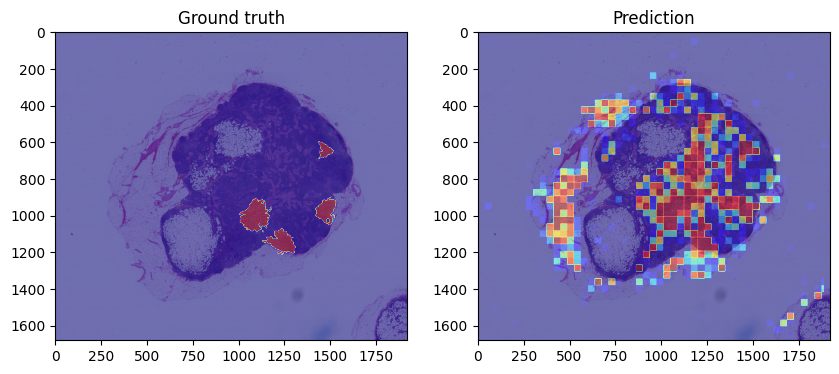

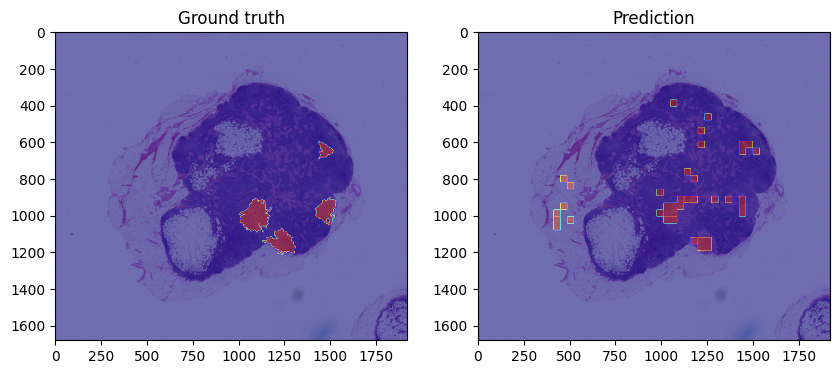

In [ ]:
plot_mask(slide, tumor_mask, heatmap, HEATMAP_LEVEL)

heatmap_threshold = np.copy(heatmap)
threshold = 0.99
heatmap_threshold[heatmap_threshold < threshold] = 0
heatmap_threshold[heatmap_threshold >= threshold] = 1
plot_mask(slide, tumor_mask, heatmap_threshold, HEATMAP_LEVEL)
report_metrics(heatmap_threshold, slide, tumor_mask, HEATMAP_LEVEL)

# Tumor 078

In [ ]:
HEATMAP_LEVEL = 5
levels = [2,3]

slidename = 'tumor_078'
slide, tumor_mask = get_slide(slidename, 'testing')
heatmap = infer_patches(slide, tumor_mask, slidename, levels[0], levels[1], 
                        HEATMAP_LEVEL)

Read WSI from /content/testing_slides/tumor_078.tif with width: 94208, height: 111104
Level 0, dimensions: (94208, 111104) downsample factor 1
Level 1, dimensions: (47104, 55552) downsample factor 2
Level 2, dimensions: (23552, 27776) downsample factor 4
Level 3, dimensions: (11776, 13888) downsample factor 8
Level 4, dimensions: (5888, 6944) downsample factor 16
Level 5, dimensions: (2944, 3472) downsample factor 32
Level 6, dimensions: (1472, 1736) downsample factor 64
Level 7, dimensions: (736, 868) downsample factor 128
Level 8, dimensions: (368, 434) downsample factor 256
Inferring patches at levels 2 and 3


The false positive rate is 7.34%
The false negative rate is 6.21%
The overall accuracy is 86.46%


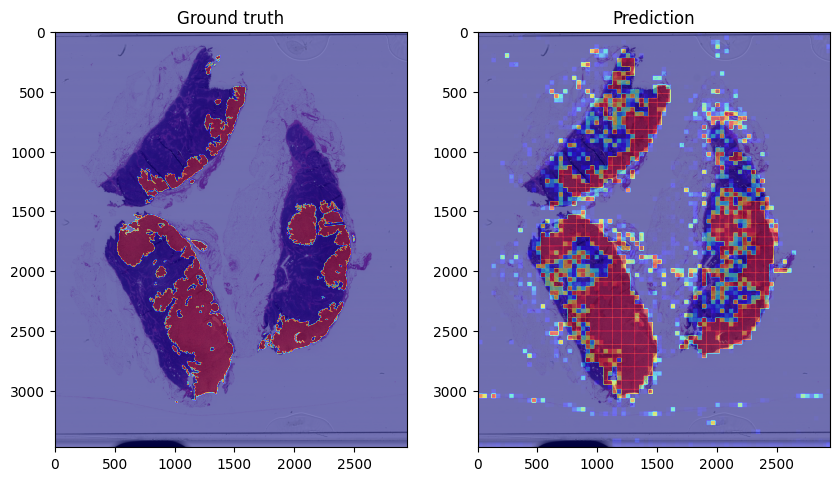

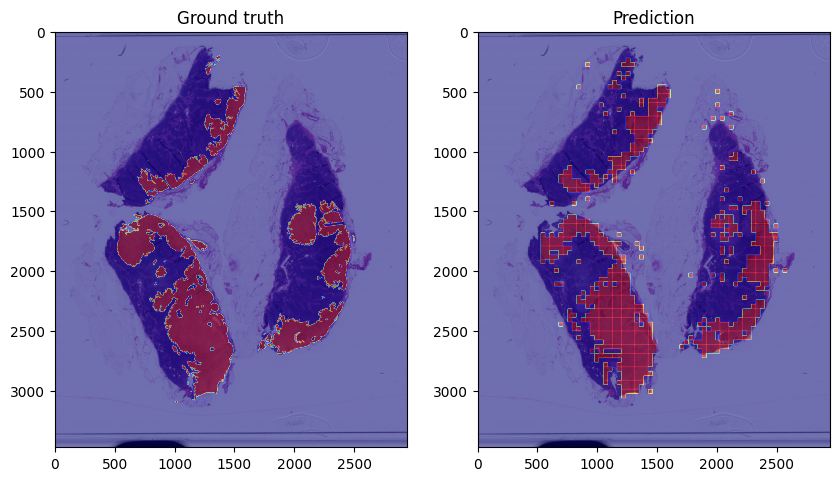

In [ ]:
plot_mask(slide, tumor_mask, heatmap, HEATMAP_LEVEL)

heatmap_threshold = np.copy(heatmap)
threshold = 0.93
heatmap_threshold[heatmap_threshold < threshold] = 0
heatmap_threshold[heatmap_threshold >= threshold] = 1
plot_mask(slide, tumor_mask, heatmap_threshold, HEATMAP_LEVEL)
report_metrics(heatmap_threshold, slide, tumor_mask, HEATMAP_LEVEL)

# Tumor 081

In [ ]:
HEATMAP_LEVEL = 5
levels = [2,3]

slidename = 'tumor_081'
slide, tumor_mask = get_slide(slidename, 'testing')
heatmap = infer_patches(slide, tumor_mask, slidename, levels[0], levels[1], 
                        HEATMAP_LEVEL)

Read WSI from /content/testing_slides/tumor_081.tif with width: 90112, height: 100352
Level 0, dimensions: (90112, 100352) downsample factor 1
Level 1, dimensions: (45056, 50176) downsample factor 2
Level 2, dimensions: (22528, 25088) downsample factor 4
Level 3, dimensions: (11264, 12544) downsample factor 8
Level 4, dimensions: (5632, 6272) downsample factor 16
Level 5, dimensions: (2816, 3136) downsample factor 32
Level 6, dimensions: (1408, 1568) downsample factor 64
Level 7, dimensions: (704, 784) downsample factor 128
Level 8, dimensions: (352, 392) downsample factor 256
Inferring patches at levels 2 and 3


The false positive rate is 0.54%
The false negative rate is 0.03%
The overall accuracy is 99.42%


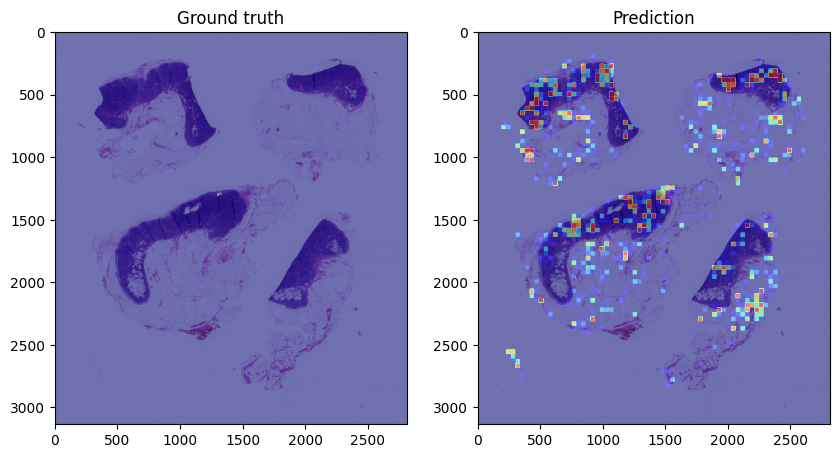

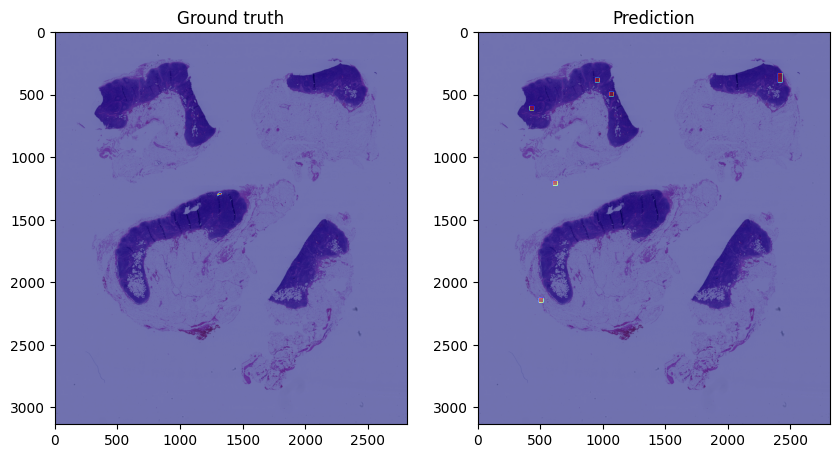

In [ ]:
plot_mask(slide, tumor_mask, heatmap, HEATMAP_LEVEL)

heatmap_threshold = np.copy(heatmap)
threshold = 0.99
heatmap_threshold[heatmap_threshold < threshold] = 0
heatmap_threshold[heatmap_threshold >= threshold] = 1
plot_mask(slide, tumor_mask, heatmap_threshold, HEATMAP_LEVEL)
report_metrics(heatmap_threshold, slide, tumor_mask, HEATMAP_LEVEL)